# Introduction

Welcome to the **Distil Labs** hands‑on tutorial for fine-tuning and deploying your own domain-specialized assistant.

In this tutorial, you’ll learn how to:

1. **Fine-tune a small language model (SLM)** for a custom open-book question answering task using the Distil Labs platform.
2. **Deploy a fully local Retrieval-Augmented Generation (RAG) system**, where the fine-tuned model answers questions based on an external knowledge source.

Our focus is on building an assistant that can answer questions about the **Roman Empire** using just a single Wikipedia page as context. You will walk through the full lifecycle—from understanding your dataset, to fine-tuning a 135M-parameter model, to deploying a self-contained RAG pipeline that runs entirely on your machine. To visualise the size of the model, take a look at the following comparison between sizes of a frontier model GPT4, llama8B which is normalluy considered a "small language model" and the 100M model we will be training in the tutorial.

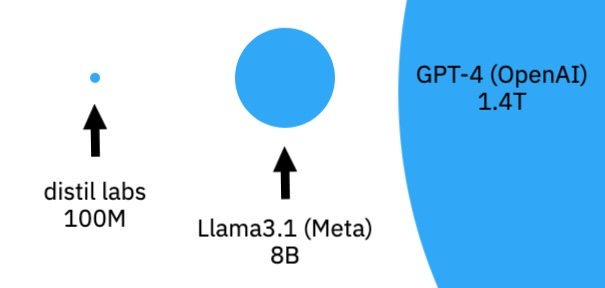

Despite its compact size, the fine-tuned SLM will deliver performance close to much larger models—demonstrating how domain specialization and efficient distillation can unlock powerful capabilities on resource-constrained hardware.

By the end, you’ll have a functional, local QA assistant—built with minimal data, no ML expertise, and zero dependency on cloud-based LLMs.

# Notebook Setup

##### Copy over necessary data

In [ ]:
%%bash
# Check if the directory exists
if [ -d "data" ]; then
  echo "Data directory does exist, nothing to do"
else
  echo "Data directory does not exist, cloning from a repository"

  # Clone the repo to a temp location
  git clone https://github.com/distil-labs/distil-labs-examples.git distil-labs-examples

  # Copy the specific subdirectory to the data directory
  cp -r distil-labs-examples/rag-tutorial/data data

  # Delete the cloned repo
  rm -rf distil-labs-examples

  echo "Subdirectory copied and repo removed."

fi

##### Install python libraries

In [ ]:
! pip install langchain-core langchain_community langchain-openai langchain-huggingface langchain-ollama
! pip install wikipedia pandas numpy requests rich pyyaml rouge_score ollama

In [ ]:
%env TOKENIZERS_PARALLELISM=false

# Step 1: Understand your data

Before we can specialize a model or build a retrieval‑augmented generation (RAG) pipeline, we need to **inspect the knowledge source** we’ll be working with. In this tutorial, our task is: **answer questions about the Roman Empire**.

_Why bother looking at the raw data first?_  
• It clarifies the scope (what’s _in_ and what’s _out_ of domain).  
• It helps us spot formatting issues or noisy sections.  
• It lets us craft realistic evaluation questions early on.

### Retrieve a reference article
To keep things quick, we’ll use a single reference document: the English **Wikipedia** page for the Roman Empire.
In a production system you’d likely combine multiple sources, but one page is enough to demo the workflow.

In [ ]:
import wikipedia, textwrap

# Disable auto-suggest so we get the exact page
page = wikipedia.page("Roman Empire", auto_suggest=False)
wikipedia_text = page.content

print("First 1200 characters of the article:\n")
print(textwrap.fill(wikipedia_text[:1200], 110))


### Sample questions we want to answer
Let’s jot down a few questions that our finished system should handle. Capturing these **early** gives us a mini test‑set for later.

In [ ]:
sample_qa = [
    {"question": "When did the Roman Empire collapse?", "answer": "The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453."},
    {"question": "Who was the first emperor of the Roman Empire?", "answer": "Augustus (formerly Octavian)"},
    {"question": "Which two languages were most widely spoken across the empire?", "answer": "Latin in the West and Greek in the East"},
    {"question": "What monumental arena in Rome hosted gladiatorial games?", "answer": "The Colosseum"},
]

for qa in sample_qa:
    print(f"Q: {qa['question']}\nA: {qa['answer']}\n")


### Why do we specialize the SLM 

Here are the answer generated by the base [HuggingFaceTB/SmolLM2-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM2-135M-Instruct) with access to the wikipedia context. Below, we will see the questions (Q) and answers (A) that we use for testing and predictions (P) generated by the model. The generated answers are not unreasonable but there is a long way to go before they can be a useful source of knowlegde. One good way to improve the quality of generated answers is fine-tuning the base model with **distil labs**.


##### Q: When did the Roman Empire collapse?

* **A:** The west Roman Empire fell in 476 CE and the East lasted until the fall of Constantinople in 1453.
* **P (one version):** The Roman Empire collapsed in the West and survived in the East.
* **P (second version):** The Roman Empire finally collapsed when Emperor Theodosius I was overthrown in 380 AD, although his heirs continued to rule until 642 AD (597 in addition). The fall is attributed to a combination of internal strife and external factors.

---

##### Q: Who was the first emperor of the Roman Empire?

* **A:** Augustus (formerly Octavian)
* **P:** The first Emperor of the Roman Empire was Constantine I in 31 BC who ruled from Milan and later became known as Emperor Constantine. He restored the Julian Code to its original form after the death of Trajan in AD 109 or possibly in 75 CE after Trajan's death in AD 98 that led to him becoming the first Emperor of the Roman Empire after his appointment by Emperor Titus in 12,651 (AD 336) from his father, Antoninus Pius.

---

##### Q: Which two languages were most widely spoken across the empire?

* **A:** Latin in the West and Greek in the East
* **P (one version):** There were not two dominant languages by the Imperial Era throughout, Rome's history it was a multi-peopelanguage that emerged.
In Roman history the Empire dominated all the major languages and dialects including Latin, which is Latin still commonly used today in many countries of the world. It wasn't until the Roman Empire collapsed after a brief period during the early Republic and the Principality (27 BC - AD 476) during the middle period that vernaculars gradually declined with the rise of Early Christianity.
`</content>`
* **P (second version):** The primary languages that were predominantly spoken throughout the Empire are Latine and Gothic or Gaulish, and also other non-Latin speaking peoples like Phoenician and Phoenician/Berber.

---

##### Q: What monumental arena in Rome hosted gladiatorial games?

* **A:** The Colosseum
* **P:** The city's famous Circus Maximus was the venue for numerous theatrical events at which gladiators fought, competed with animals such as bulls and donkeys etc., alongside other spectacular presentations.


# Step 2: Specialize a Question-Answering Model with distil labs

In this chapter you will transform a compact **135 M-parameter** “student” model
into a domain expert—without writing a single training loop yourself.
Distil Labs takes care of every heavy-lifting step:

| Stage | What happens under the hood | Why it matters |
| ----- | --------------------------- | -------------- |
| **Data upload & validation** | You submit a *job description*, tiny train / test CSVs, and (optionally) an **unstructured corpus**. The platform checks schema, finds label mistakes, and estimates achievable accuracy. | Catches data bugs before you waste compute. |
| **Teacher evaluation** | A large foundation model (“teacher”) answers your test questions. Distil Labs measures accuracy and shows a pass/fail report. | If the teacher can’t solve the task, small models won’t either—stop here instead of two hours later. |
| **SLM training (synthetic generation + distillation)** | *Automatically* generates additional Q&A pairs from your corpus to fill knowledge gaps, then fine-tunes the 135 M student with LoRA/QLoRA adapters while distilling the teacher’s reasoning. Lightweight hyper-parameter search runs in the background. | Produces a model up to **70 × smaller** than the teacher yet usually within a few percentage points of its accuracy—ready for CPU-only devices. |
| **Benchmarking & packaging** | Once training finishes, Distil Labs re-evaluates both teacher and student on your held-out test set, generates a side-by-side metrics report, and bundles the weights in an Ollama-ready tarball. | You get hard numbers *and* a model you can run locally in one command. |


**What you need to supply**

* A concise *job description* that tells the platform what “good” looks like  
* Roughly **20–100** labeled (question, answer) pairs for train / test  
* Any domain documents you want the teacher to read while inventing synthetic Q&A pairs

Everything else (synthetic generation, distillation, evaluation, and packaging) is automated.  
Let’s dive in and see how that looks in practice.


### Authentification

In [ ]:
import json
import os
import requests


def distil_bearer_token(DL_USERNAME: str, DL_PASSWORD: str) -> str:
    response = requests.post(
        "https://cognito-idp.eu-central-1.amazonaws.com",
        headers={
            "X-Amz-Target": "AWSCognitoIdentityProviderService.InitiateAuth",
            "Content-Type": "application/x-amz-json-1.1",
        },
        data=json.dumps({
            "AuthParameters": {
                "USERNAME": DL_USERNAME,
                "PASSWORD": DL_PASSWORD,
            },
            "AuthFlow": "USER_PASSWORD_AUTH",
            "ClientId" : "4569nvlkn8dm0iedo54nbta6fd",
        })
    )
    response.raise_for_status()
    return response.json()["AuthenticationResult"]["AccessToken"]


DL_USERNAME="DL_USERNAME"
DL_PASSWORD="DL_PASSWORD"

AUTH_HEADER = {"Authorization": distil_bearer_token(DL_USERNAME, DL_PASSWORD)}
print("Success")

### Data Upload

The data for this example should be stored in the data_location directory. Lets first take a look at the current directory to make sure all files are available. Your current directory should look like:
```
├── README.md
├── rag-tutorial.ipynb
└── data
    ├── job_description.json
    ├── test.csv
    ├── train.csv
    └── unstructured.csv
```

#### Job Description
A job description explains the question answering task in plain english and follows the general structure below:

In [ ]:
import json
from pathlib import Path
import rich.json

with open(Path("data").joinpath("job_description.json")) as fin:
    rich.print(rich.json.JSON(fin.read()))

#### Train/test set

We need a small train dataset to begin distil labs training and a testing dataset that we can use to evaluate the performance of the fine-tuned model. Here, we use the train and test datasets from the data_location directory where each is a CSV file with below 100 (question, answer) pairs.

In [ ]:
from pathlib import Path
from IPython.display import display

import pandas as pd

print("# --- Train set")
train = pd.read_csv(Path("data").joinpath("train.csv"))
display(train)

print("# --- Test set")
test = pd.read_csv(Path("data").joinpath("test.csv"))
display(test)

#### Unstructured dataset
The unstructured dataset is used to guide the teacher model in generating diverse, domain-specific data. Here, we will use the chunks of the wikipedia article as the unstructured data for our problem.

In [ ]:
import pandas as pd
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Split the document into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_text(wikipedia_text)

# Save the documents into local storage
contexts_dataframe = pd.DataFrame([{"context": split} for split in all_splits])
contexts_dataframe.to_csv("data/unstructured.csv")
contexts_dataframe

#### Data upload

In [ ]:
import json

import requests
import yaml
from pathlib import Path

# Specify the config
config = {
    "base": {"task": "question-answering-open-book"},
    "setup": {"student_model_name": "HuggingFaceTB/SmolLM2-135M-Instruct"},
    "synthgen": {
        "data_generation_strategy": "qa-open-book",
    },
    "tuning": {
        "num_train_epochs": 8,
    },
}

# Package your data
data_dir = Path("data")
data = {
    "job_description.json": open(data_dir / "job_description.json", encoding="utf-8").read(),
    "train.csv": open(data_dir / "train.csv", encoding="utf-8").read(),
    "test.csv": open(data_dir / "test.csv", encoding="utf-8").read(),
    "unstructured.csv": open(data_dir / "unstructured.csv", encoding="utf-8").read(),
    "config.yaml": yaml.dump(config),
}

# Upload data
response = requests.post(
    "https://api.distillabs.ai/uploads",
    data=json.dumps(data),
    headers={"content-type": "application/json", **AUTH_HEADER},
)
upload_id = response.json().get("id")
print(f"Upload successful. ID: {upload_id}")


### Teacher Evaluation
Before training an SLM, distil labs validates whether a large language model can solve your task:

In [ ]:
from pprint import pprint

# Start teacher evaluation
response = requests.post(
    f"https://api.distillabs.ai/teacher-evaluations/{upload_id}",
    headers=AUTH_HEADER
)

teacher_evaluation_id = response.json().get("id")
pprint(response.json())

Poll the status endpoint until it completes, then inspect the quality of generated answers. distil labs shows four scores to tell you how well the “teacher” model answers your test questions. Think of them as different lenses on the same picture—together they give a fuller view than any single number

| Metric                   | What it really asks                                                                                     | How to read it                                                                                                                                                |
| ------------------------ | ------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Exact-Match (Binary)** | “Did the model give *exactly* the same words as the reference answer?”                                  | 1 = perfect match, 0 = anything else. Great for facts that have one correct phrasing, harsh on synonyms. ([Wikipedia][1])                                     |
| **LLM-as-a-Judge**       | “If we let a large language model act as a human grader, does it say this answer is good?”              | Scores reflect semantic quality even when wording differs; handy when many answers are possible. ([Evidently AI][2], [arXiv][3])                              |
| **ROUGE-L**              | “How much word-overlap is there between answer and reference?” (counts the longest common subsequence). | Higher = more shared wording; favours longer answers that reuse reference phrases. Widely used in text-summarisation tests. ([Wikipedia][4])                  |
| **METEOR**               | “Do the two answers share words *or* close synonyms/stems, and is the wording fluent?”                  | Balances precision + recall, rewards correct synonyms, penalises word-salad; often tracks human judgements better than pure overlap metrics. ([Wikipedia][5]) |

---

##### How to interpret a scorecard

* If Exact-Match is low but LLM-as-a-Judge is high, the answers are probably *right but paraphrased*—consider adding those paraphrases to your reference set.
* If all four numbers sag, revisit your job description or give the model more context; the task may be under-specified.

Follow the links above for deeper dives if you want to explore the math or research behind each metric.

[1]: https://en.wikipedia.org/wiki/Language_model_benchmark "Language model benchmark"
[2]: https://www.evidentlyai.com/llm-guide/llm-as-a-judge "LLM-as-a-judge: a complete guide to using LLMs for evaluations"
[3]: https://arxiv.org/abs/2411.15594 "[2411.15594] A Survey on LLM-as-a-Judge - arXiv"
[4]: https://en.wikipedia.org/wiki/ROUGE_%28metric%29 "ROUGE (metric)"
[5]: https://en.wikipedia.org/wiki/METEOR "METEOR"



In [ ]:

from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/teacher-evaluations/{teacher_evaluation_id}/status",
    headers=AUTH_HEADER
)
pprint(response.json())


### SLM Training
Once the teacher evaluation completes successfully, start the SLM training:

In [ ]:
import time
from pprint import pprint

# Start SLM training
response = requests.post(
    f"https://api.distillabs.ai/trainings/{upload_id}",
    headers=AUTH_HEADER,
)

pprint(response.json())
slm_training_job_id = response.json().get("id")

We can analyze the status of the training job using the `jobs` API. The following code snippets displays the current status of the job we started before. When the job is finished (`status=complete`), we can use the `jobs` API again to get the benchmarking result - the accuracy of the LLM and the accuracy of the fine-tuned SLM. We can achieve this using:

In [ ]:
import json
from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/status",
    headers=AUTH_HEADER,
)
pprint(response.json())

When the job is finished (`status=complete`), we can use the `jobs` API again to get the benchmarking result for the base and fine-tuned SLM, using the same four metrics as for the teacher evaluation. We can achieve this using:

In [ ]:
from pprint import pprint

response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/evaluation-results",
    headers=AUTH_HEADER,
)

pprint(response.json())


### Download Your Model
Once training is complete, download your model for deployment.

In [ ]:
from pprint import pprint

# Get model download URL
response = requests.get(
    f"https://api.distillabs.ai/trainings/{slm_training_job_id}/model",
    headers=AUTH_HEADER
)

s3url = response.json()["s3_url"]
pprint(response.json())

In [ ]:
import tarfile
import urllib.request

print("Downloading …")
urllib.request.urlretrieve(s3url, "model.tar")

print("Unpacking …")
with tarfile.open("model.tar", mode="r:*") as tar:
    tar.extractall(path=".")


In [ ]:
!ls -lt

# Step 3: Build a local RAG system with your fine‑tuned model

Now that we have a small language model fine‑tuned specifically for Roman‑Empire question‑answering, we can build our RAG pipeline around it. This domain‑specialized LLM will provide more accurate, context‑aware answers than our baseline model while still running entirely on local hardware. The main objectives for us are as follows:
  * Launch a lightweight chat model locally with **ollama**.
  * Chunk a Wikipedia article, embed the chunks with **HuggingFace sentence‑transformers**, and store them in an **in‑memory vector store**.
  * Glue retrieval and generation together in a minimal **RAG class**, then test the loop end‑to‑end.

#### Install ollama

To install ollama, follow the instructions in https://ollama.com/download. If you are on a linux platform the following command should get the job done but otherwise, the download page should cover the installation

In [ ]:
! curl -fsSL https://ollama.com/install.sh | sh

Once ollama is installed, we should start the application. If you installed ollama using the installer, make sure the app is running. If you installed ollama with with CLI, you can start the deamon with `ollama serve`, for example using `nohup` to make sure it stays in the bacgkround.

In [ ]:
! nohup ollama serve

Make sure the app is running by executing 

In [ ]:
! ollama list

### Register and test the downloaded model 
Once your model is trained, it should be unpacked and registered with ollama. The downloaded model directory already contains everything that is needed and the model can be registed with the command below. Once it is ready, we can test the model with a standard OPenAI interface

In [ ]:
! ollama create model-distillabs -f model/Modelfile

In [ ]:
from openai import OpenAI

client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

response = client.chat.completions.create(
  model="model-distillabs",
  messages=[
    {"role": "user", "content": "When did the roman empire collapse?"},
  ]
)
print(response.choices[0].message.content)

### Index our target dataset

This section walks through loading the **Wikipedia article on the Roman Empire** into an in‑memory vector store (adapted from [https://python.langchain.com/docs/tutorials/rag/](https://python.langchain.com/docs/tutorials/rag/)):

In [ ]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# Split the document into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splits = text_splitter.split_text(wikipedia_text)
document_splits = text_splitter.create_documents(text_splits)

# Embed and index the chunks
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")
vector_store = InMemoryVectorStore(embeddings)
indexed = vector_store.add_documents(documents=document_splits)

### Define the RAG logic

Now that our dataset is indexed and the chat model is live, we can **wire retrieval and generation together**. In this section we implement a bite‑sized `RAG` helper class that

1. fetches the top‑k passages most similar to the user’s question,
2. feeds those passages and the question into the language model via a structured prompt, and
3. returns a concise answer.

With this plumbing in place, answering a question becomes a single‑function call.

In [ ]:
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_core.vectorstores import InMemoryVectorStore


class RAG:
    def __init__(self, vector_store: InMemoryVectorStore, llm: ChatOpenAI):
        self.vector_store = vector_store
        self.llm = llm

        self.SYSTEM_PROMPT = """
You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>

You will be given a single task with context in the context XML block and the task in the question XML block
Solve the task in question block based on the context in context block.
Generate only the answer, do not generate anything else
"""

        self.PROMPT_TEMPLATE = """
Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
{context}
</context>

<question>
{question}
</question>
"""

    def retrieve(self, question: str, k: int = 3):
        return self.vector_store.similarity_search(question, k=k)

    def generate(self, question: str, context_docs):
        context = "\n\n".join(doc.page_content for doc in context_docs)
        messages = [
            {"role": "system", "content": self.SYSTEM_PROMPT},
            {"role": "user", "content": self.PROMPT_TEMPLATE.format(context=context, question=question)},
        ]
        return self.llm.invoke(messages).content

    def answer(self, question: str):
        return self.generate(question, self.retrieve(question))

### Plug the new model into RAG
With the fine‑tuned weights now running locally, the last step is to introduce the specialized LLM into our existing RAG helper class. The retrieval component fetches the most relevant passages about the Roman Empire—while the generation step leverages a model that has been trained on our domain‑specific data.

In [ ]:
from langchain_openai import ChatOpenAI

tuned_llm = ChatOpenAI(
    base_url='http://localhost:11434/v1',
    api_key="EMPTY",
    model="model-distillabs",
)
tuned_rag = RAG(vector_store=vector_store, llm=tuned_llm)
print(tuned_rag.answer("When did the roman empire collapse?"))

### Test our RAG system

In [ ]:
sample_qa = [
    {"question": "When did the Roman Empire collapse?", "answer": "The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453."},
    {"question": "Who was the first emperor of the Roman Empire?", "answer": "Augustus (formerly Octavian)"},
    {"question": "Which two languages were most widely spoken across the empire?", "answer": "Latin in the West and Greek in the East"},
    {"question": "What monumental arena in Rome hosted gladiatorial games?", "answer": "The Colosseum"},
]

for qa in sample_qa:
    print(f"Q: {qa['question']}\nA: {qa['answer']}\nP:{tuned_rag.answer(qa['question'])}\n")